## Project: Recurring FIN3080 Project 1

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat July 12 17:36:01 2021

@author: Bradley

Code for recurring FIN3080 Project 1 - Case 2
"""

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' 

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 

#### 本文实证可使用CSMAR, WIND, 或者预测者网的数据

#### 本文实证选用2006年1月1日至2021年6月25日的股票月度数据，沪深主板（包括中小板）的数据

#### 主要目的是探究市值因子、PB、上月收益率三个单因子的效果，验证分为十个portfolio进行多空/挑选部分股票与大盘对比

#### 进一步的策略会放到聚宽中实现，考虑到手续费滑点印花税佣金等等因素

#### 为了保证策略的准确性，我购买了预测者网至2021-7-12的全部股票（包括主流指数）的月线数据，涨跌幅是复权后的数据。以后的所有需要手动回测、使用月线数据的project均可使用该数据。预测者网的数据包括了每月最后一天是否交易、涨跌停的信息，总市值流通市值、市净率TTM和市现率TTM、市净率（股价/最近期财报每股净资产）、成交量成交额换手率、每月股票交易天数等信息，十分全面，可以充分的筛选，也可以满足project1 case2的所有数据需求

#### 使用预测者网的数据，可以很快的删除退市、停牌的股票、ST股、交易天数少的股票（可能是*ST股或新股）、月末调仓时涨跌停的股票。以后回测周度、日度的股票和指数数据也可以使用预测者网

In [2]:
# 导入预测者网数据并做筛选
df = pd.read_csv('./all_stock_data_monthly/stock_data.csv', encoding='gbk')
df = df[['交易日期','股票代码','涨跌幅','流通市值','总市值','交易天数','是否交易','是否涨停','是否跌停','市净率']]
df['交易日期'] = pd.to_datetime(df['交易日期'],format='%Y-%m-%d')
df = df[df['交易日期'] > pd.to_datetime('2006-01-01')]
# 注意！！！要shift一步，因为我们这月底的调仓考察收益的是下一个月回报率！！！
df.sort_values(by=['股票代码','交易日期'], inplace=True)
# df['下月回报率'] = df['涨跌幅'].shift(-1)
# 这样直接移动的后果是每个股票最后一个交易日的“下月回报率”是错误的，清理起来很麻烦
df['下月回报率'] = df.groupby('股票代码')['涨跌幅'].shift(-1) # 每组内运用shift

# #无奈之举，如果这个月的下个月都没有交易，那shift来的“下月收益率”显然就不能使用
# from datetime import timedelta #这步要跑很久，三十多分钟，要么想办法加速。应该把数据处理中间结果保存，保存成csv或hdf。
# for i in range(df.shape[0]):
#     try:
#         if df.iloc[i+1]['交易日期'] - df.iloc[i]['交易日期'] > timedelta(33):
#             df.drop(df.index[i],inplace=True)
#     except:
#         continue

# 上面那个for循环要跑三十多分钟。然而，有一个4s就可以解决问题的办法，并且只用两行：diff+apply函数
df['delta'] = df['交易日期'].diff().shift(-1).apply(lambda x: x.days) #apply把timedelta转成int
df = df[df['delta'] <= 32]

df.dropna(subset=['下月回报率'], inplace=True)
df

,交易日期,股票代码,涨跌幅,流通市值,总市值,交易天数,是否交易,是否涨停,是否跌停,市净率,下月回报率
74,2006-01-25,sh600000,0.155898,1.014300e+10,4.412205e+10,16.0,1.0,0.0,0.0,2.978765,0.081631
75,2006-02-24,sh600000,0.081631,1.097100e+10,4.772385e+10,14.0,1.0,0.0,0.0,3.221925,-0.109107
77,2006-05-31,sh600000,0.209055,1.166490e+10,3.903255e+10,13.0,1.0,0.0,0.0,3.278472,-0.006018
78,2006-06-30,sh600000,-0.006018,1.159470e+10,3.879765e+10,21.0,1.0,0.0,0.0,3.258741,-0.112007
79,2006-07-31,sh600000,-0.112007,1.029600e+10,3.445200e+10,21.0,1.0,0.0,0.0,2.893739,0.117045
...,...,...,...,...,...,...,...,...,...,...,...
592042,2021-06-30,sz301012,3.318012,6.920000e+08,2.920000e+09,7.0,1.0,0.0,0.0,NaN,-0.018987
592044,2021-06-30,sz301013,3.231651,1.227000e+09,5.750000e+09,2.0,1.0,0.0,0.0,NaN,-0.266667
592046,2021-06-30,sz301015,6.350785,2.496000e+09,2.949000e+10,1.0,1.0,0.0,0.0,NaN,-0.396189
592048,2021-06-30,sz301016,2.137455,1.227000e+09,5.177000e+09,1.0,1.0,0.0,0.0,NaN,-0.321743


In [3]:
df = df.sort_values(by=['交易日期','股票代码'])
df = df[df['是否交易'] != 0] # 剔除月末停牌股票，万科在2015年12月18日停牌，2016年7月4日复牌，12月31日那天不能买入
df = df[df['交易天数'] >= 10] # 去除交易时间过段的股票，可能*ST或新股
df = df[df['是否涨停'] == 0] # 去除月末涨跌停的股票
df = df[df['是否跌停'] == 0]
df.set_index('交易日期', inplace=True)
df['股票代码'] = df['股票代码'].str[2:]
# 只取开头为000,60,002，不要300创业板，68科创板还有B股
df = df[df['股票代码'].str.startswith('00') | df['股票代码'].str.startswith('60')] # | 代表或，& 代表和，~ 代表取反
df

,股票代码,涨跌幅,流通市值,总市值,交易天数,是否交易,是否涨停,是否跌停,市净率,下月回报率
交易日期,,,,,,,,,,
2006-01-20,600012,0.036665,1.555000e+09,7.250032e+09,13.0,1.0,0.0,0.0,2.347039,-0.048232
2006-01-20,600037,0.166333,3.614844e+09,1.054270e+10,13.0,1.0,0.0,0.0,4.725135,-0.084996
2006-01-20,600059,0.194355,8.113014e+08,1.773936e+09,13.0,1.0,0.0,0.0,1.512539,-0.044619
2006-01-20,600216,0.342611,8.285629e+08,2.821876e+09,13.0,1.0,0.0,0.0,4.024965,-0.039873
2006-01-20,600220,0.169083,1.209641e+09,2.332802e+09,13.0,1.0,0.0,0.0,0.984925,-0.028926
...,...,...,...,...,...,...,...,...,...,...
2021-06-30,003040,-0.193916,2.383000e+09,1.401900e+10,21.0,1.0,0.0,0.0,NaN,-0.066118
2021-06-30,003041,-0.072131,7.080000e+08,2.830000e+09,21.0,1.0,0.0,0.0,NaN,-0.074912
2021-06-30,003042,-0.121259,7.720000e+08,3.090000e+09,21.0,1.0,0.0,0.0,NaN,-0.017382


In [4]:
df.isnull().sum()

股票代码         0
涨跌幅          0
流通市值         0
总市值          0
交易天数         0
是否交易         0
是否涨停         0
是否跌停         0
市净率      94781
下月回报率        0
dtype: int64

In [5]:
zhongzheng500 = pd.read_csv('./all_stock_data_monthly/index data/sz399905.csv',encoding='gbk')
zhongzheng500.set_index('交易日期',inplace=True)
zhongzheng500 = zhongzheng500[['涨跌幅']]
zhongzheng500 = zhongzheng500.rename(columns={'涨跌幅':'中证500涨跌幅'})
hushen300 = pd.read_csv('./all_stock_data_monthly/index data/sh000300.csv',encoding='gbk')
hushen300.set_index('交易日期',inplace=True)
hushen300 = hushen300[['涨跌幅']]
hushen300 = hushen300.rename(columns={'涨跌幅':'沪深300涨跌幅'})
shangzheng50 = pd.read_csv('./all_stock_data_monthly/index data/sh000016.csv',encoding='gbk')
shangzheng50.set_index('交易日期',inplace=True)
shangzheng50 = shangzheng50[['涨跌幅']]
shangzheng50 = shangzheng50.rename(columns={'涨跌幅':'上证50涨跌幅'})

benchmark = pd.concat([zhongzheng500,hushen300,shangzheng50],join='outer',axis=1)
benchmark.sort_index(inplace=True)
benchmark[['中证500涨跌幅','沪深300涨跌幅','上证50涨跌幅']] = benchmark[['中证500涨跌幅','沪深300涨跌幅','上证50涨跌幅']].shift(-1) #平移一位保持一致
benchmark.columns=['下月中证500回报','下月沪深300回报','下月上证50回报']
benchmark = benchmark.loc['2006-01-01':,:]
benchmark.drop(['2021-06-30','2021-07-12'], inplace=True) #最后一天是7月12日，剔除掉;为了对齐，6月30也删了
benchmark.tail()

,下月中证500回报,下月沪深300回报,下月上证50回报
2021-01-29,0.002869,-0.002840,0.011744
2021-02-26,-0.017328,-0.054040,-0.057891
2021-03-31,0.037038,0.014882,-0.013613
2021-04-30,0.037510,0.040613,0.045552
2021-05-31,0.011768,-0.020169,-0.041524


In [6]:
# 很恶心的一点，这个数据排出来，股票最后一天不是一样的，有2006-01-25，有2006-01-23，他是按该股票最后一天交易时间算的，然后他那个“是否交易”是根据这一天是否在交易来算的，比如sh600001，在2006年1月最后一天交易是2006-01-20，但“是否交易”也显示的1，所以我要根据指数的这个index把里面日期不是这个的剔除
index_list = pd.to_datetime(benchmark.index.tolist())
all_list = df.index.tolist()
nums = [i for i in all_list if i not in index_list]
nums = list(set(nums)) # 去除重复时间
nums.sort()
df = df.drop(nums)
df

,股票代码,涨跌幅,流通市值,总市值,交易天数,是否交易,是否涨停,是否跌停,市净率,下月回报率
交易日期,,,,,,,,,,
2006-01-25,600000,0.155898,1.014300e+10,4.412205e+10,16.0,1.0,0.0,0.0,2.978765,0.081631
2006-01-25,600008,0.132377,3.798000e+09,1.392600e+10,16.0,1.0,0.0,0.0,3.119367,-0.050552
2006-01-25,600015,0.124472,6.396000e+09,2.238600e+10,16.0,1.0,0.0,0.0,2.179211,0.135083
2006-01-25,600022,0.153349,1.174800e+09,5.019600e+09,16.0,1.0,0.0,0.0,1.259577,0.033708
2006-01-25,600058,0.107016,1.476540e+09,5.218200e+09,16.0,1.0,0.0,0.0,1.771780,0.030110
...,...,...,...,...,...,...,...,...,...,...
2021-05-31,003040,0.193121,2.964000e+09,1.743600e+10,18.0,1.0,0.0,0.0,NaN,-0.193916
2021-05-31,003041,0.044521,7.620000e+08,3.050000e+09,18.0,1.0,0.0,0.0,NaN,-0.072131
2021-05-31,003042,-0.039808,8.790000e+08,3.516000e+09,18.0,1.0,0.0,0.0,NaN,-0.121259


In [7]:
df.to_csv('./processed_data/processed_stock_data_monthly.csv',encoding='gbk')

In [8]:
benchmark.fillna(value=0, inplace=True) #不知道为什么数据没有2006年的中证500涨跌幅，暂时填充成0
benchmark['市场平均回报'] = df.groupby(level=0)['下月回报率'].mean() #level参数代表直接对index进行分组
df['同期市值排名'] = df.groupby(level=0)['总市值'].rank() #groupby+rank提供组内排名，每月的市值排名，顺序排名，所以第一名最小
df2 = df[df['同期市值排名'] <= 10]
benchmark['小市值策略回报'] = df2.groupby(level=0)['下月回报率'].mean()
benchmark['小市值策略所选股票'] = df2.groupby(level=0)['股票代码'].apply(lambda f: '|'.join(np.array(f).tolist()))
benchmark.tail()

,下月中证500回报,下月沪深300回报,下月上证50回报,市场平均回报,小市值策略回报,小市值策略所选股票
2021-01-29,0.002869,-0.002840,0.011744,0.038939,0.179499,600091|600112|600146|600247|600385|600687|6007...
2021-02-26,-0.017328,-0.054040,-0.057891,0.032153,0.126323,600086|600112|600146|600385|603996|000835|0020...
2021-03-31,0.037038,0.014882,-0.013613,0.007369,0.017802,600091|600112|600146|600385|000662|000835|0020...
2021-04-30,0.037510,0.040613,0.045552,0.054923,0.124495,600091|600146|600385|600599|600766|603996|0008...
2021-05-31,0.011768,-0.020169,-0.041524,0.017023,0.200259,600146|600385|600766|603996|000609|000611|0008...


In [9]:
benchmark.head()

,下月中证500回报,下月沪深300回报,下月上证50回报,市场平均回报,小市值策略回报,小市值策略所选股票
2006-01-25,0.0,0.043000,0.054210,0.039571,0.060567,600065|600340|600532|600562|600566|600766|6008...
2006-02-28,0.0,0.007671,-0.016282,0.006364,-0.048156,600137|600234|600286|600691|600762|600847|6008...
2006-03-31,0.0,0.104854,0.098000,0.070904,-0.112006,600137|600234|600286|600629|600691|600745|6007...
2006-04-28,0.0,0.164716,0.118635,0.257872,0.383063,600137|600234|600385|600681|600691|600721|6007...
2006-05-31,0.0,0.020881,0.022091,0.058020,0.112699,600137|600234|600691|600711|600745|600892|0000...


In [10]:
benchmark.to_csv('./result/size_factor.csv', encoding='gbk', columns=['小市值策略回报','市场平均回报','下月中证500回报','下月沪深300回报','下月上证50回报','小市值策略所选股票'],index=True)

<AxesSubplot:>

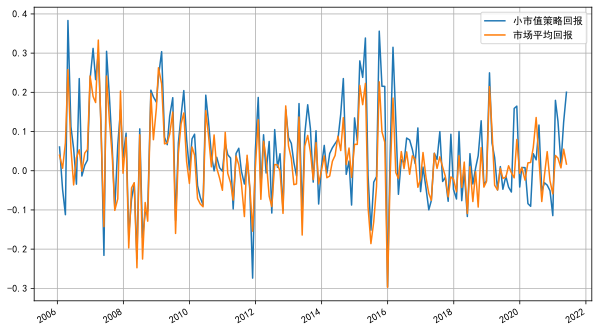

In [8]:
benchmark = pd.read_csv('./result/size_factor.csv', encoding='gbk',index_col=0, parse_dates=True)
fig, ax = plt.subplots(1,1,figsize=(10,6))
benchmark[['小市值策略回报','市场平均回报']].plot(ax=ax, grid=True, legend=True) 
plt.savefig('./figures/figure0.png',dpi=1000)

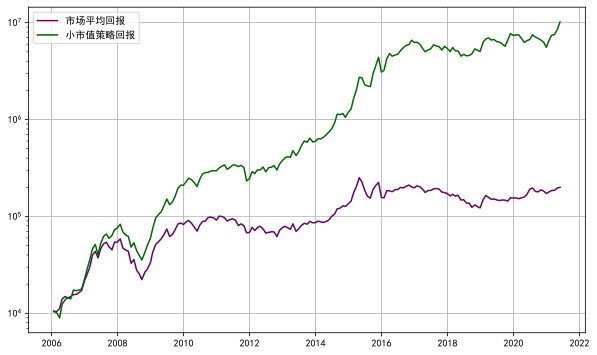

In [9]:
# 考虑起始10000元的累计收益曲线
initial = 10000
strategy_cumulative_return = np.cumprod(1+benchmark['小市值策略回报'])
market_cumulative_return = np.cumprod(1+benchmark['市场平均回报'])

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(initial*market_cumulative_return, color='#660066', label='市场平均回报')
ax.plot(initial*strategy_cumulative_return, color='#006600', label='小市值策略回报')
plt.grid(True)
plt.legend(loc='best')
# ax.set_xticklabels(labels=benchmark.index.tolist(), rotation=45)
# from matplotlib import ticker
# ticker_spacing = 15
# ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
ax.set_yscale('log')
plt.savefig('./figures/figure1.png',dpi=1000)

In [ ]:
# 起始10000元的累计收益面积图
initial = 10000
strategy_cumulative_return = np.cumprod(1+benchmark['小市值策略回报'])
market_cumulative_return = np.cumprod(1+benchmark['市场平均回报'])
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.stackplot(benchmark.index, initial*market_cumulative_return, initial*strategy_cumulative_return,colors=['#660066','#660606'], labels=['市场平均回报','小市值策略回报'])
plt.grid(True)
plt.legend(loc='best')
ax.set_yscale('log')
plt.savefig('./figures/figure1_1.png', dpi=1000)


<AxesSubplot:>

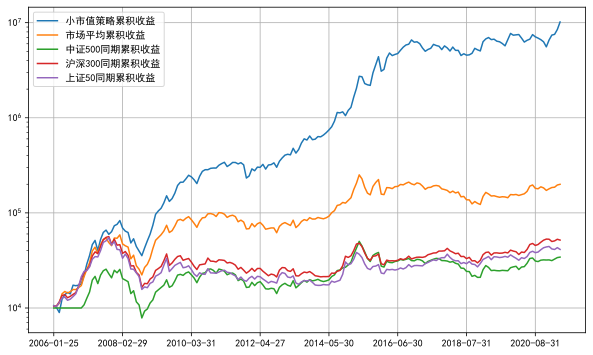

In [14]:
initial = 10000
new_df = pd.DataFrame()
new_df['小市值策略累积收益'] = initial*np.cumprod(1+benchmark['小市值策略回报'])
new_df['市场平均累积收益'] = initial*np.cumprod(1+benchmark['市场平均回报'])
new_df['中证500同期累积收益'] = initial*np.cumprod(1+benchmark['下月中证500回报'])
new_df['沪深300同期累积收益'] = initial*np.cumprod(1+benchmark['下月沪深300回报'])
new_df['上证50同期累积收益'] = initial*np.cumprod(1+benchmark['下月上证50回报']) #上证50都是大市值股票，尤其拿来做对比
fig, ax = plt.subplots(1,1,figsize=(10,6))
new_df.plot(ax=ax, grid=True, label=True, logy=True)
plt.savefig('./figures/figure1_2.png', dpi=1000)

#### 以上策略基本就完成了，分组的依据可以改成pb，改成本月涨跌幅也就是本月收益率，然后持有十只股票与市场/指数进行比较，只用改一行就可以实现，不再赘述了。图片还有可以继续美化的空间，加上置信区间阴影之类的。产出表格和图片就可以写报告了。这也就是测试单因子的一个纯手写的方法，当然在聚宽里可以轻松写ipynb进行因子分析，画出热力图IC等等很牛逼的图表和表格可视化，还可以更严谨的写py文件设置税费跑回测，更严谨的交易环境
#### 下面手动写一些策略的评价指标函数，方便日后使用

In [88]:
# 最大回撤与总回报率
def max_drawdown(X): #这里的accumulate可以考虑换成cummax、cummin的函数
    i = np.argmax((np.maximum.accumulate(X) - X)/np.maximum.accumulate(X))
#   i是什么？由于这里是accumulate函数，i代表一个index，该index使得对应的那个收盘价减去之前（注意由于accumulate所以是之
#     前）的所有收盘价最大的那个再除以那个最大的收盘价中的最小值。也就是我们直接找到了目标最大回撤发生的两个时间点的后一个
#     时间点。想知道这个时间点，直接输出i就可以。然后锁定了这个位置，再遍历这个index之前的收盘价的最大值所在处，就是最大回撤
#     发生的前一个时间点，然后输出即可。
    j = np.argmax(X[:i]) # 最大回撤发生时间点的前一个时间点
    return (X[j]-X[i])/X[j], i, j
# max_drawdown(np.array(str_return))

def cumulative_return(obj: pd.Series):
    arr = np.array(obj)
    return arr[-1]-

def max_drawdown_and_total_return(asset:np.array):
    ret = (asset[-1]-initial)/initial 
    maxdd = max_drawdown(asset)
    return maxdd, ret

def ret_weight(df:pd.DataFrame, weight:np.array): 
    mean = df.mean()*252
    return sum(weight * mean)

def std_weight(df:pd.DataFrame, weight:np.array): 
    cov = df.cov()*252
    var = np.dot(weight, cov)
    var = np.dot(var, weight.T)
    std = np.sqrt(var)
    return std

def annalized_return(df: pd.Series):


def main():
    frame = pd.read_csv('./result/size_factor.csv', encoding='gbk',index_col=0, parse_dates=True)
    del frame['小市值策略所选股票']
    str_return = frame[['小市值策略回报']]
    
    date = frame.index.tolist() # 日期序列
    str_ret = initial * (1+frame[['小市值策略回报']]).cumprod() # 累积收益序列
    mar_ret = initial * (1+frame[['市场平均回报']]).cumprod() # 累积收益序列
    benchmark_ret = initial * (1+frame[['下月沪深300回报']]).cumprod() # 累积收益序列

    result = pd.DataFrame()
    a, b = max_drawdown_and_total_return(np.array(str_ret))
    result['最大回撤'] = a[0]
    result['最大回撤区间'] = [(date[a[2]].strftime("%Y-%m-%d"), date[a[1]].strftime("%Y-%m-%d"))]
    result['累计收益率'] = '%.4f%%'%(b[0]*100)

    result['基准收益'] = '%.4f%%'%((np.array(benchmark_ret)[-1]-initial)/initial*100)
    result['胜率'] = '%.4f%%'%(frame[frame['小市值策略回报']>frame['下月沪深300回报']].shape[0]/frame.shape[0]*100)

    result = result.T
    result.columns = ['数据汇总']
    result.index.name = '策略评估'
    return result
main()


,数据汇总
策略评估,
最大回撤,0.572719
最大回撤日期,"(2008-01-31, 2008-09-26)"
总回报率,101534.5335%
基准收益,417.4388%
胜率,65.4054%


In [49]:
frame = pd.read_csv('./result/size_factor.csv', encoding='gbk',index_col=0, parse_dates=True)
del frame['小市值策略所选股票']
str_return = frame[['小市值策略回报']]
frame.head()

,小市值策略回报,市场平均回报,下月中证500回报,下月沪深300回报,下月上证50回报
2006-01-25,0.060567,0.039571,0.0,0.043000,0.054210
2006-02-28,-0.048156,0.006364,0.0,0.007671,-0.016282
2006-03-31,-0.112006,0.070904,0.0,0.104854,0.098000
2006-04-28,0.383063,0.257872,0.0,0.164716,0.118635
2006-05-31,0.112699,0.058020,0.0,0.020881,0.022091


---
---

#### 下分十个组合探究case2

In [7]:
# 市值划分
bec = pd.read_csv('./processed_data/processed_stock_data_monthly.csv', encoding='gbk')
bec['股票代码'] = bec['股票代码'].map(lambda x: '%06d'%x)
bec['rank'] = bec.groupby('交易日期')['总市值'].rank(pct=True)
mkt_group = pd.DataFrame()
for i in range(10):
    sub_group = bec[(bec['rank'] <= 0.1*(i+1)) & (bec['rank'] > 0.1*i)] #用这些%、|符号记得加括号
    mkt_group['group%s'%(i+1)] = sub_group.groupby('交易日期')['下月回报率'].mean()
mkt_group.to_csv('./result/group_by_size.csv', encoding='gbk', index=True)

In [8]:
# 本月收益率划分
bec = pd.read_csv('./processed_data/processed_stock_data_monthly.csv', encoding='gbk')
bec['股票代码'] = bec['股票代码'].map(lambda x: '%06d'%x)
bec['rank'] = bec.groupby('交易日期')['涨跌幅'].rank(pct=True)
last_ret_group = pd.DataFrame()
for i in range(10):
    sub_group = bec[(bec['rank'] <= 0.1*(i+1)) & (bec['rank'] > 0.1*i)] #用这些%、|符号记得加括号
    last_ret_group['group%s'%(i+1)] = sub_group.groupby('交易日期')['下月回报率'].mean()
last_ret_group.to_csv('./result/group_by_last_return.csv', encoding='gbk', index=True)

In [9]:
# 市净率划分
bec = pd.read_csv('./processed_data/processed_stock_data_monthly.csv', encoding='gbk')
bec['股票代码'] = bec['股票代码'].map(lambda x: '%06d'%x)
bec.dropna(subset=['市净率'], inplace=True)
bec['rank'] = bec.groupby('交易日期')['市净率'].rank(pct=True)
pb_group = pd.DataFrame()
for i in range(10):
    sub_group = bec[(bec['rank'] <= 0.1*(i+1)) & (bec['rank'] > 0.1*i)] #用这些%、|符号记得加括号
    pb_group['group%s'%(i+1)] = sub_group.groupby('交易日期')['下月回报率'].mean()
pb_group.to_csv('./result/group_by_PB.csv', encoding='gbk', index=True)

<AxesSubplot:xlabel='交易日期'>

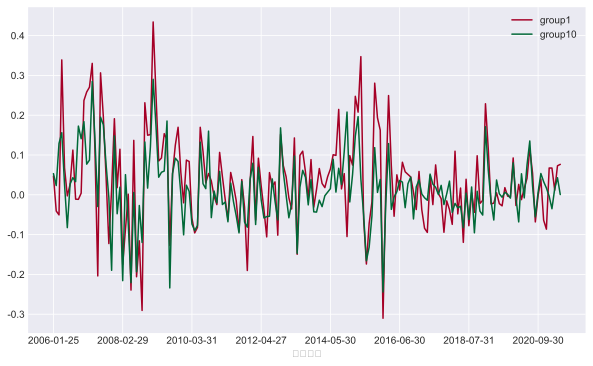

In [50]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
plt.style.use('seaborn-dark')
# 这里可以轻松使用colormap，在plt.plot中是cmap参数，调整不同的背景色，实现不同的炫酷效果。如果是scatter或者hexbin还可以设置更多的colorbar色阶。设置colormap就好比mplfinance里面设置背景主色一样，下面的所有图形折线都会在这个背景色下完成，就很好看。而这里我们分是个portfolio就是想从1到10折线颜色从深到浅再到深这种变化，就可以实现。
mkt_group[['group1','group10']].plot(ax=ax, kind='line', grid=True, colormap='RdYlGn',figsize=(10,6), legend=True)
plt.savefig('./figures/group_by_mkt_return.png', dpi=1000)

<AxesSubplot:xlabel='交易日期'>

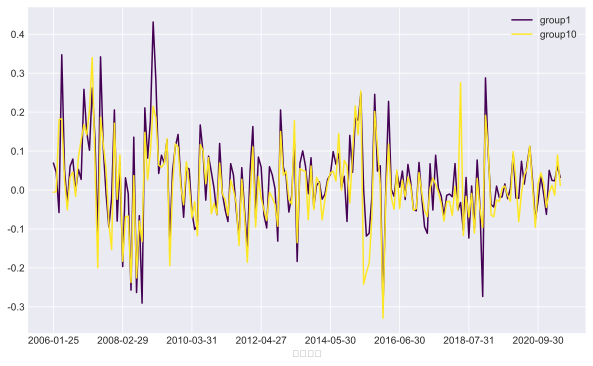

In [51]:
last_ret_group[['group1','group10']].plot(kind='line', grid=True, colormap='viridis',figsize=(10,6), legend=True)
plt.savefig('./figures/group_by_last_ret_return.png', dpi=1000)

<AxesSubplot:xlabel='交易日期'>

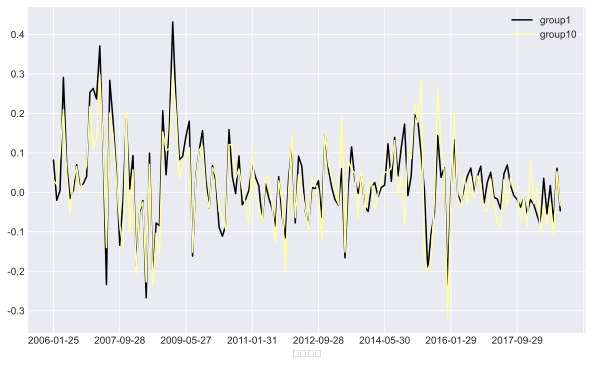

In [52]:
pb_group[['group1','group10']].plot(kind='line', grid=True, colormap= 'inferno',figsize=(10,6), legend=True)
plt.savefig('./figures/group_by_pb_return.png', dpi=1000)

### 十个组合收益率的图

<AxesSubplot:xlabel='交易日期'>

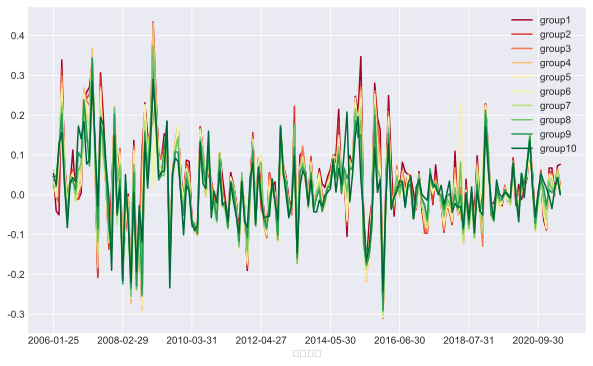

In [54]:
mkt_group.plot(kind='line', grid=True, colormap='RdYlGn',figsize=(10,6), legend=True)
plt.savefig('./figures/group_by_mkt_return_all.png', dpi=1000)

<AxesSubplot:xlabel='交易日期'>

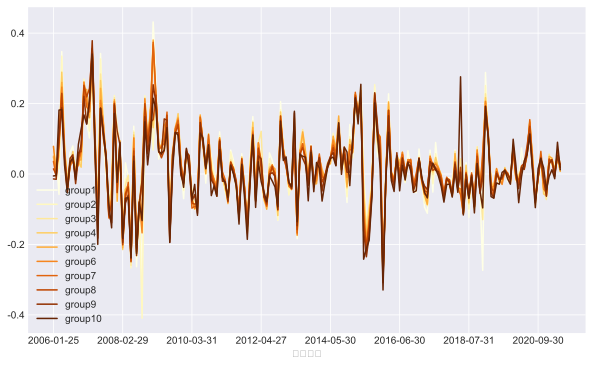

In [55]:
last_ret_group.plot(kind='line', grid=True, colormap='YlOrBr',figsize=(10,6), legend=True)
plt.savefig('./figures/group_by_last_ret_return_all.png', dpi=1000)

<AxesSubplot:xlabel='交易日期'>

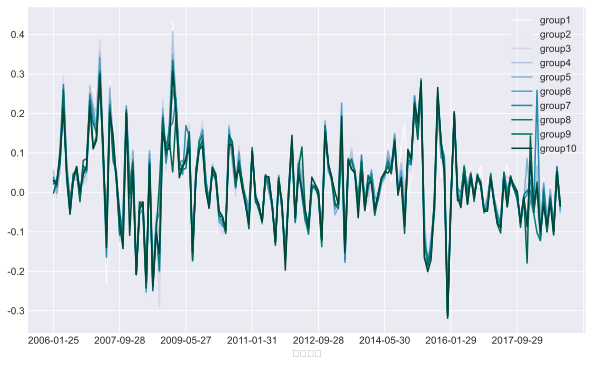

In [56]:
pb_group.plot(kind='line', grid=True, colormap='PuBuGn',figsize=(10,6), legend=True)
plt.savefig('./figures/group_by_pb_return_all.png', dpi=1000)


<AxesSubplot:xlabel='交易日期'>

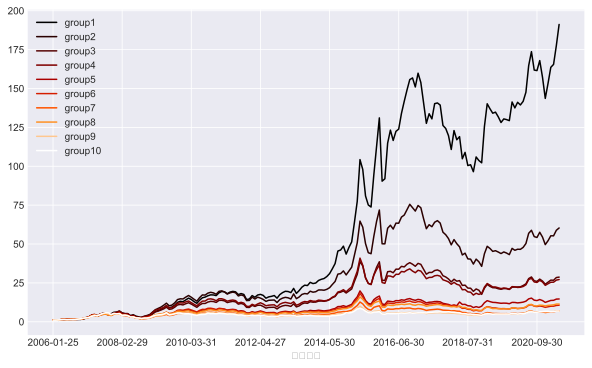

In [57]:
(1+mkt_group).cumprod().plot(kind='line', grid=True, colormap='gist_heat',figsize=(10,6), legend=True)
plt.savefig('./figures/group_by_mkt_cum_return.png', dpi=1000)


#### 可以看出，小市值组合远远的outperform

<AxesSubplot:xlabel='交易日期'>

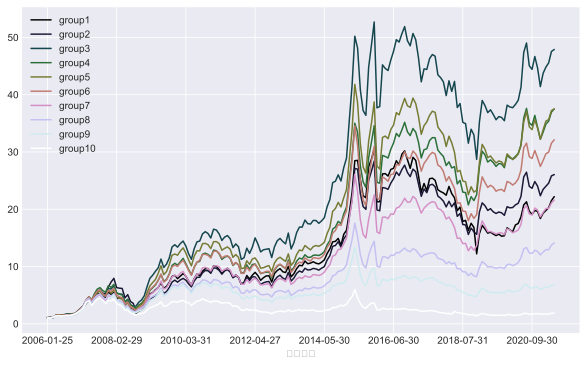

In [58]:
(1+last_ret_group).cumprod().plot(kind='line', grid=True, colormap='cubehelix',figsize=(10,6), legend=True)
plt.savefig('./figures/group_by_last_ret_cum_return.png', dpi=1000)


#### group10是本月涨幅最大的组合，可以看出追涨杀跌死得很惨啊。

<AxesSubplot:xlabel='交易日期'>

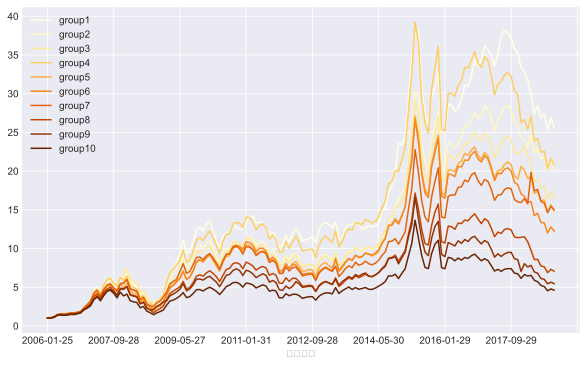

In [59]:
(1+pb_group).cumprod().plot(kind='line', grid=True, colormap='YlOrBr',figsize=(10,6), legend=True)
plt.savefig('./figures/group_by_pb_cum_return.png', dpi=1000)

In [ ]:
# 面积图，贼壮观，模仿聚宽的效果
(1+mkt_group).cumprod().plot(kind='area', grid=True, colormap='gist_heat',figsize=(10,6), legend=True)
(1+last_ret_group).cumprod().plot(kind='area', grid=True, colormap='cubehelix',figsize=(10,6), legend=True)
(1+pb_group).cumprod().plot(kind='area', grid=True, colormap='YlOrBr',figsize=(10,6), legend=True)


#### 可以看出，PB低的股票，价值股，的确表现很好。

### Case2就此完成了。小市值策略的确很强，他在2006-2016之间涨了400多倍，在2006-2021年5月涨了1000倍，但同时在2016到2018之间经历了一个很大的回测（50%+），在零八年左右也发生了50%+的最大回撤水平，风险还是太大。而且并未考虑各种手续费印花税滑点等等，严谨的还是要到聚宽里面跑。

### 有时间可以完善一下这里的策略评估函数，写好了以后都能用，不用非要在平台使用。



------

#### 下面是用wind数据做废的结果，前面的处理流程也可以学习下，后面就不用了。因为wind数据根本无法筛选退市、停牌这之类的股票，我只能根据名字来筛选。而且也没有“下月收益率”这一列，很难处理，也不知道下个月这个股票是否仍然交易，不知道股票交易天数，新股之类的情况，以后这种实证还是用预测者网的数据比较好。即使用预测者网，我这个case里面处理数据也处理了很久，主要麻烦在于得到下个月的收益率，要保证下个月股票在交易，而不能直接shift。所以要sort遍历一个for循环，那一步程序要跑半个多小时。日后看看可不可以加速这个过程，写成apply函数之类的，或者用别的方法加速。然后处理好的数据我已经保存到processed_data里面，防止重复跑浪费时间。

In [260]:
# Wind下载数据为全体A股数据，首先数据筛选
# 只取开头为000,60,002，不要300创业板，68科创板还有B股
data = pd.read_csv('./data/case2_data.csv',encoding='gbk')
data.columns = ['code','name', 'date','pre_close', 'close', 'pct_change', 'mkt_cap', 'pb_ratio']
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data = data[data['code'].str.startswith('00') | data['code'].str.startswith('60')] # | 代表或，& 代表和
data = data[~data['name'].str.contains('退') & ~data['name'].str.contains('ST')] # 去除退市和ST，*ST股
print(len(data['code'].unique())) 
data

2923


,code,name,pre_close,close,pct_change,mkt_cap,pb_ratio
date,,,,,,,
2006-01-25,000001.SZ,平安银行,153.5943,158.8475,3.4202,1.235597e+10,2.4638
2006-02-28,000001.SZ,平安银行,158.8475,171.1051,7.7165,1.330942e+10,2.6539
2006-03-31,000001.SZ,平安银行,171.1051,159.3479,-6.8713,1.239489e+10,2.4716
2006-04-28,000001.SZ,平安银行,159.3479,197.1211,23.7049,1.533308e+10,2.9127
2006-05-31,000001.SZ,平安银行,197.1211,219.6349,11.4213,1.708432e+10,3.2454
...,...,...,...,...,...,...,...
2021-02-26,605500.SH,森林包装,18.1800,18.3100,0.7151,3.662000e+09,3.3764
2021-03-31,605500.SH,森林包装,18.3100,19.6800,7.4823,3.936000e+09,3.6290
2021-04-30,605500.SH,森林包装,19.6800,18.6600,-5.1829,3.732000e+09,1.7506


#### 退市或停牌的股票，在聚宽中很容易筛除，或者邢不行那里下一个月度数据或者自己从日度做一个月度数据，包括股票的一个月最后一天的收益率，交易天数，以及该月最后一天是否有交易，因为我们在每个月末调仓，需要这个股票在月末有交易。这里直接wind给的数据和CSMAR下载的月度数据比较粗糙，数据是直接前复权的，我还不记得CSMAR哪里有说他数据是前复权还是后复权，而且就算涨跌幅不为空值，也可能是拿着月中的收盘价与月初的收盘价算的，而实际上月末这天股票可能并未交易。所以最严谨的方法当然还是用量化平台，或者用日度数据升采样到月度数据，自己整理一份。这里就粗糙一点了，直接筛去所有空缺的股票，显然涨跌幅空缺意味着这个月可能都没有交易。而且这里下载的PB我也不知道是静态还是动态还是TTM。

In [261]:
data.isnull().sum() #391880条数据中，涨跌幅仅有1754条数据缺失，全部剔除（不过PB这里只有八条缺失，下文做PB重新筛选一遍）
data.dropna(axis=0, subset=['pct_change'], inplace=True)
data.sort_values(by=['date', 'code'], inplace=True)
data['pct_change'] = 0.01*data['pct_change'] #万得数据单位是%
data

code             0
name             0
pre_close     1754
close            0
pct_change    1754
mkt_cap          0
pb_ratio         8
dtype: int64

,code,name,pre_close,close,pct_change,mkt_cap,pb_ratio
date,,,,,,,
2006-01-25,000001.SZ,平安银行,153.5943,158.8475,0.034202,1.235597e+10,2.4638
2006-01-25,000002.SZ,万科A,190.7025,218.1353,0.143852,1.835285e+10,2.7235
2006-01-25,000004.SZ,国华网安,12.9418,13.0981,0.012077,3.518623e+08,3.9303
2006-01-25,000006.SZ,深振业A,18.6982,29.3742,0.570960,1.417577e+09,1.4077
2006-01-25,000008.SZ,神州高铁,10.2807,10.7112,0.041872,3.115531e+08,4.4427
...,...,...,...,...,...,...,...
2021-06-25,605398.SH,新炬网络,44.9300,42.6800,-0.050078,2.539384e+09,2.6973
2021-06-25,605399.SH,晨光新材,18.3566,19.7834,0.077729,3.597200e+09,3.0049
2021-06-25,605488.SH,福莱新材,31.2000,27.7800,-0.109615,3.333600e+09,7.0875


#### 还是说的，这里就粗糙处理了，严谨来看，应该看月度最后一天是否股票在交易，同时那些这个月交易天数比较少的股票也应该剔除，因为可能是ST股或者什么新股，这些股票我们都不想要。所以还是应该有一份严谨的数据，有一列标注是否月末是交易日，有一列表明该月股票交易天数，这里就不用管这些了，缺失的都剔除了，默认剩的这些股票都倍棒月末还是交易日。邢不行就在Excel直接把交易天数<=10的都删除了。

#### 除了上面那些没交易的，交易天数少的（新股、ST等等），还要考虑涨停跌停！所以，如果是在月末调仓，还应有一列是“月末最后一天的涨跌幅”，判断这天有没有出现涨跌停，如果出现，好像也可以交易，但是这里就把他们删掉了。A股涨跌幅限制似乎为10%，邢不行设置为9.97%，筛掉这些股票。

#### 当然，wind和CSMAR数据上什么都没写，那就只能不管了。最后写报告的时候把不足之处全归结为数据。

#### 其实这样处理也是有问题的，比如ST股涨停限制为5%，所以更严谨的是要么ST股单独处理，要么不管ST股直接扔掉。

#### 接下来的探究方法有两种。一种是作业说的，分十个portfolio做多空组合。但其实由于A股不能做空，这样其实意义不大。另一种就是像聚宽那样搞回测了，找一个基准，然后选小市值股票（比如十只股票），收益率与基准对比，产出夏普、最大回撤等等这些指标。这里我一并下载了同期指数的月收益率，可以选择不同的基准进行对比。

#### 我犯了个错，指数我是下载到6月30日，股票只下载到6月25日，现在匹配有问题。。。强行把指数最后一天改成6-25

In [262]:
# 方法一：以同期全市场的平均月收益率作为基准
# 直接这样得到的平均月收益率可以作为market return的月收益率，等权法，就不用再从CSMAR下载了
benchmark = pd.read_excel('./data/index_data.xlsx', sheet_name='万得',skiprows=1)
benchmark.set_index('时间',inplace=True)
benchmark.rename(index={datetime(2021, 6, 30):datetime(2021, 6, 25)}, inplace=True) #没办法把指数最后一天改成6月25日
benchmark['市场平均回报'] = df.groupby(level=0)['pct_change'].mean() #level参数代表直接对index进行分组
benchmark.dropna(how='all', inplace=True)
benchmark['沪深300'] = benchmark['沪深300']*0.01
benchmark['中证500'] = benchmark['中证500']*0.01 #换单位
benchmark['上证50'] = benchmark['上证50']*0.01
benchmark['上证指数'] = benchmark['上证指数']*0.01

benchmark.tail()

KeyError: 'Column not found: pct_change'

In [263]:
# 排序股票
# 策略一：每月底只取市值最小的十只股票，然后和指数对比（10年400倍的策略）
df['rank'] = df.groupby(level=0)['mkt_cap'].rank() #groupby+rank提供组内排名，每月的市值排名，顺序排名，所以第一名最小
df = df[df['rank'] <= 10]
benchmark['小市值回报'] = df.groupby(level=0)['pct_change'].mean()
benchmark['所选股票'] = df.groupby(level=0)['code'].sum() # 输出每期选的股票
benchmark.to_csv('./result/size_factor.csv', encoding='gbk', columns=['小市值回报','市场平均回报','中证500','沪深300','上证50','上证指数','所选股票'],index=True)

KeyError: 'Column not found: mkt_cap'

In [264]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
benchmark[['小市值回报','市场平均回报']].plot(ax=ax, grid=True, legend=True, sharex=True) 

KeyError: "None of [Index(['小市值回报', '市场平均回报'], dtype='object')] are in the [columns]"

In [265]:
# 考虑起始10000元的累计收益曲线
initial = 10000
strategy_cumulative_return = np.cumprod(1+benchmark['小市值回报'])
market_cumulative_return = np.cumprod(1+benchmark['市场平均回报'])

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(initial*market_cumulative_return, color='#660066', label='市场平均回报')
ax.plot(initial*strategy_cumulative_return, color='#006600', label='小市值策略回报')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('./figures/figure1.png',dpi=1000)

KeyError: '小市值回报'

In [266]:
initial = 10000
new_df = pd.DataFrame()
new_df['小市值策略累积收益'] = np.cumprod(1+benchmark['小市值回报'])
new_df['市场平均累积收益'] = np.cumprod(1+benchmark['市场平均回报'])
new_df['中证500同期累积收益'] = np.cumprod(1+benchmark['中证500'])
new_df['沪深300同期累积收益'] = np.cumprod(1+benchmark['沪深300'])
new_df['上证50同期累积收益'] = np.cumprod(1+benchmark['上证50']) #上证50都是大市值股票，尤其拿来做对比
fig, ax = plt.subplots(1,1,figsize=(10,6))
new_df.plot(ax=ax, grid=True, label=True, logy=True)

KeyError: '小市值回报'

In [267]:
# 计算夏普、最大回撤、总回报率等常用策略指标
df.loc['2021-05-31']


,股票代码,涨跌幅,流通市值,总市值,交易天数,是否交易,是否涨停,是否跌停,市净率,下月回报率,同期市值排名
交易日期,,,,,,,,,,,
2021-05-31,600000,0.021891,3.014470e+11,3.014470e+11,18.0,1.0,0.0,0.0,NaN,-0.026290,2945.0
2021-05-31,600004,-0.046875,2.398300e+10,2.743000e+10,18.0,1.0,0.0,0.0,NaN,-0.035375,2517.0
2021-05-31,600006,0.129688,1.446000e+10,1.446000e+10,18.0,1.0,0.0,0.0,NaN,0.009682,2173.0
2021-05-31,600007,0.592539,2.236200e+10,2.236200e+10,18.0,1.0,0.0,0.0,NaN,-0.174145,2415.0
2021-05-31,600008,0.009862,2.150800e+10,2.150800e+10,18.0,1.0,0.0,0.0,NaN,0.027304,2402.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,003040,0.193121,2.964000e+09,1.743600e+10,18.0,1.0,0.0,0.0,NaN,-0.193916,2290.0
2021-05-31,003041,0.044521,7.620000e+08,3.050000e+09,18.0,1.0,0.0,0.0,NaN,-0.072131,668.0
2021-05-31,003042,-0.039808,8.790000e+08,3.516000e+09,18.0,1.0,0.0,0.0,NaN,-0.121259,843.0
